# Homework and bakeoff: Multi-domain sentiment

In [75]:
__author__ = "Christopher Potts"
__version__ = "CS224u, Stanford, Spring 2023"

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/cgpotts/cs224u/blob/main/hw_sentiment.ipynb)

If Colab is opened with this badge, please **save a copy to drive** (from the File menu) before running the notebook.

## Overview

This homework and associated bakeoff are devoted to supervised sentiment analysis in a ternary label setting (positive, negative, neutral). Your ultimate goal is to develop systems that can make accurate predictions in multiple domains.

The homework questions ask you to implement some baseline systems using DynaSent Round 1, DynaSent Round 2, and the Stanford Sentiment Treebank. The bakeoff challenge is to define a system that does well on the DynaSent test sets, the SST-3 test set, and a set of mystery examples that don't correspond to the DynaSent or SST-3 domains.

__Important methodological note:__ The DynaSent and SST-3 test sets are already publicly distributed, so we are counting on people not to cheat by developing their models on these test sets. You must do all your development without using these test sets at all, and then evaluate exactly once on the test set and turn in the results, with no further system tuning or additional runs. _Much of the scientific integrity of our field depends on people adhering to this honor code._

This notebook briefly introduces our three development datasets, states the homework questions, and then provides guidance on the original system and associated bakeoff entry.

## Set-up

In [76]:
try:
    # Sort of randomly chosen import to see whether the requirements
    # are met:
    import datasets
except ModuleNotFoundError:
    !git clone https://github.com/cgpotts/cs224u/
    !pip install -r cs224u/requirements.txt
    import sys
    sys.path.append("cs224u")

In [77]:
from collections import defaultdict, Counter
from datasets import load_dataset
import pandas as pd
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
import torch

## Datasets

### DynaSent round 1

The DynaSent dataset of [Potts, Wu, et al. 2021](https://aclanthology.org/2021.acl-long.186/) is a ternary sentiment benchmark consisting of two rounds (so far). The dataset is available on [Hugging Face](https://huggingface.co/datasets/dynabench/dynasent).

For Round 1, the authors collected sentences from the [Yelp Academic Dataset](https://www.yelp.com/dataset) that fooled a top-performing sentiment model but were intuitive for humans. The model was used only to heuristically find the examples. Crowdworkers multiply-labeled all of them.

The round contains a lot of metadata that could be useful for developing sentiment models. We will focus on just the sentences and labels, but you are free to make use of this additional metadata in developing uour system.

In [78]:
dynasent_r1 = load_dataset("dynabench/dynasent", 'dynabench.dynasent.r1.all', trust_remote_code=True)

Repo card metadata block was not found. Setting CardData to empty.


In [79]:
dynasent_r1

DatasetDict({
    train: Dataset({
        features: ['id', 'hit_ids', 'sentence', 'indices_into_review_text', 'model_0_label', 'model_0_probs', 'text_id', 'review_id', 'review_rating', 'label_distribution', 'gold_label', 'metadata'],
        num_rows: 80488
    })
    validation: Dataset({
        features: ['id', 'hit_ids', 'sentence', 'indices_into_review_text', 'model_0_label', 'model_0_probs', 'text_id', 'review_id', 'review_rating', 'label_distribution', 'gold_label', 'metadata'],
        num_rows: 3600
    })
    test: Dataset({
        features: ['id', 'hit_ids', 'sentence', 'indices_into_review_text', 'model_0_label', 'model_0_probs', 'text_id', 'review_id', 'review_rating', 'label_distribution', 'gold_label', 'metadata'],
        num_rows: 3600
    })
})

Splits:

In [80]:
def print_label_dist(dataset, labelname='gold_label', splitnames=('train', 'validation')):
    for splitname in splitnames:
        print(splitname)
        dist = sorted(Counter(dataset[splitname][labelname]).items())
        for k, v in dist:
            print(f"\t{k:>14s}: {v}")

In [81]:
print_label_dist(dynasent_r1)

train
	      negative: 14021
	       neutral: 45076
	      positive: 21391
validation
	      negative: 1200
	       neutral: 1200
	      positive: 1200


### DynaSent round 2

DynaSent Round 2 was created using different methods than Round 1. For Round 2, crowdworkers edited sentences from the Yelp Academic Dataset seeking to achieve a particular sentiment goal (e.g., expressing a positive sentiment) while fooling a top-performing model. This work was done on the [Dynabench](https://dynabench.org) platform. The hope is that this directly adversarial goal will lead to examples that are very hard for present-day models but intuitive for humans. All the examples were multiply-labeled by separate annotators.

In [82]:
dynasent_r2 = load_dataset("dynabench/dynasent", 'dynabench.dynasent.r2.all', trust_remote_code=True)

Repo card metadata block was not found. Setting CardData to empty.


In [83]:
print_label_dist(dynasent_r2)

train
	      negative: 4579
	       neutral: 2448
	      positive: 6038
validation
	      negative: 240
	       neutral: 240
	      positive: 240


### Stanford Sentiment Treebank

The [Stanford Sentiment Treebank (SST)](http://nlp.stanford.edu/sentiment/) of [Socher et al. 2013](https://aclanthology.org/D13-1170/) is a widely-used resource for evaluating supervised models. It consists of sentences from Rotten Tomatoes Movie Reviews (see [Pang and Lee's project page](https://www.cs.cornell.edu/home/llee/papers/pang-lee-stars.home.html)). We will use the ternary version of the task (SST-3).

SST examples are special in that they are labeled at the phrase-level as well as the sentence level, which provides very extensive and detailed supervision for sentiment. We will use only the sentence-level labels for the homework, but you are free to use the phrase-level labels as well in designing your original system. (To do this, you will need to get the dataset from the above project page, since the Hugging Face SST-3 we are using does not include these labels.)

In [84]:
sst = load_dataset("SetFit/sst5", trust_remote_code=True)

Repo card metadata block was not found. Setting CardData to empty.


In [85]:
sst

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 8544
    })
    validation: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 1101
    })
    test: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 2210
    })
})

Out of the box, this is a five-way task:

In [86]:
print_label_dist(sst, labelname='label_text')

train
	      negative: 2218
	       neutral: 1624
	      positive: 2322
	 very negative: 1092
	 very positive: 1288
validation
	      negative: 289
	       neutral: 229
	      positive: 279
	 very negative: 139
	 very positive: 165


The above labels are not aligned with our ternary task, and the dataset distribution uses slightly different keys from those of DynaSent. The following code converts the dataset to SST-3 and also aligns the dataset keys:

In [87]:
def convert_sst_label(s):
    return s.split(" ")[-1]

In [88]:
for splitname in ('train', 'validation', 'test'):
    dist = [convert_sst_label(s) for s in sst[splitname]['label_text']]
    sst[splitname] = sst[splitname].add_column('gold_label', dist)
    sst[splitname] = sst[splitname].add_column('sentence', sst[splitname]['text'])

In [89]:
print_label_dist(sst)

train
	      negative: 3310
	       neutral: 1624
	      positive: 3610
validation
	      negative: 428
	       neutral: 229
	      positive: 444


## Question 1: Linear classifiers

Our first set of experiments will use simple linear classifiers with sparse representations derived from counting unigrams. These experiments will introduce some useful techniques and provide a baseline for original systems.

### Background: Feature functions

The following is a flexible format for writing feature functions in the context of scikit-learn modeling. The function maps a string to a count dictionary, using the simple procedure of splitting on whitespace and counting the resulting elements:

In [90]:
def unigrams_phi(s):
    """The basis for a unigrams feature function.

    Downcases all tokens.

    Parameters
    ----------
    s : str
        The example to represent

    Returns
    -------
    Counter
        A map from tokens (str) to their counts in `text`

    """
    return Counter(s.lower().split())

Quick example:

In [91]:
unigrams_phi("Here's an example with an emoticon :)!")

Counter({"here's": 1,
         'an': 2,
         'example': 1,
         'with': 1,
         'emoticon': 1,
         ':)!': 1})

### Background: Feature space vectorization

Functions like `unigrams_phi`  are just the __basis__ for feature representations. In truth, our models typically don't represent examples as dictionaries, but rather as vectors embedded in a matrix. In general, to manage the translation from dictionaries to vectors, we use [sklearn.feature_extraction.DictVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html) instances. Here's a brief overview of how these work:

To start, suppose that we had just two examples to represent, and our feature function mapped them to the following list of dictionaries:

In [92]:
train_feats = [
    {'a': 1, 'b': 1},
    {'b': 1, 'c': 2}]

Now we create a `DictVectorizer`. So that we can more easily inspect the resulting matrix, I've set `sparse=False`, so that the return value is a dense matrix. For real problems, you'll probably want to use `sparse=True`, as it will be vastly more efficient for the very sparse feature matrices that you are likely to be creating.

In [93]:
vec = DictVectorizer(sparse=False)  # Use `sparse=True` for real problems!

The `fit_transform` method maps our list of dictionaries to a matrix:

In [94]:
X_train = vec.fit_transform(train_feats)

Here I'll create a `pd.Datafame` just to help us inspect `X_train`:

In [95]:
pd.DataFrame(X_train, columns=vec.get_feature_names_out())

,a,b,c
0,1.0,1.0,0.0
1,0.0,1.0,2.0


Now we can see that, intuitively, the feature called "a" is embedded in the first column, "b" in the second column, and "c" in the third.

Now suppose we have some new test examples:

In [96]:
test_feats = [
    {'a': 2, 'c': 1},
    {'a': 4, 'b': 2, 'd': 1}]

If we have trained a model on `X_train`, then it will not have any way to deal with this new feature "d". This shows that we need to embed `test_feats` in the same space as `X_train`. To do this, one just calls `transform` on the existing vectorizer:

In [97]:
X_test = vec.transform(test_feats)  # Not `fit_transform`!

In [98]:
pd.DataFrame(X_test, columns=vec.get_feature_names_out())

,a,b,c
0,2.0,0.0,1.0
1,4.0,2.0,0.0


The most common mistake with `DictVectorizer` is calling `fit_transform` on test examples. This will wipe out the existing representation scheme, replacing it with one that matches the test examples. That will happen silently, but then you'll find that the new representations are incompatible with the model you fit. This is likely to manifest itself as a `ValueError` relating to feature counts. Here's an example that might help you spot this if and when it arises in your own work:

In [99]:
toy_mod = LogisticRegression()

vec = DictVectorizer(sparse=False)

X_train = vec.fit_transform(train_feats)

toy_mod.fit(X_train, [0, 1])

# Here's the error! Don't use `fit_transform` again!
# Use `transform`!
X_test = vec.fit_transform(test_feats)

try:
    toy_mod.predict(X_test)
except ValueError as err:
    print("ValueError: {}".format(err))

ValueError: X has 4 features, but LogisticRegression is expecting 3 features as input.


### Background: scikit-learn models

scikit-learn is an amazing package with, among many other things, an incredible array of classifier model implementations. We're going to use a simple softmax classifier for this homework question, but you will find that you can swap in essentially any scikit-learn classifier and see how it does.

The core rhythm for scikit-learn models:

1. Instantiate the model with any hyperparamters.
2. `fit`
3. `predict`

Here's a quick example that also shows off scikit-learn's functionality for creating synthetic datasets and random train/test splits:

In [100]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X_toy, y_toy = make_classification(
    n_samples=200, n_classes=3,
    n_informative=15, n_features=20,
    weights=[0.2, 0.2, 0.6],
    random_state=1)

X_toy_train, X_toy_test, y_toy_train, y_toy_test = train_test_split(
    X_toy, y_toy, test_size=0.20, stratify=y_toy, random_state=1)

toymod = LogisticRegression(penalty='l2', C=1, fit_intercept=True)

toymod.fit(X_toy_train, y_toy_train)

toypreds = toymod.predict(X_toy_test)

### Background: Classifier assessment

When assessing a classifier, the best first step is usually to get a classification report:

In [101]:
from sklearn.metrics import classification_report

print(classification_report(y_toy_test, toypreds, digits=3))

              precision    recall  f1-score   support

           0      0.444     0.500     0.471         8
           1      0.444     0.500     0.471         8
           2      0.909     0.833     0.870        24

    accuracy                          0.700        40
   macro avg      0.599     0.611     0.604        40
weighted avg      0.723     0.700     0.710        40



In this course, we will generally focus in the __macro-average F1 score__ (macro avg above). This is simply the mean of the per-class F1 scores, without any attention paid to the overall size of the class. This is our default because, in NLP, we tend to care about small classes as much as (often more than) large classes.

The scikit-learn implementation of `macro_f1` can be finicky, so our course code provides a convenient wrapper:

In [102]:
import utils

utils.safe_macro_f1(y_toy_test, toypreds)

0.6035805626598466

Note: scikit-learn models have a `score` method. For classifiers, this is set to use `accuracy` by default:

In [103]:
toymod.score(X_toy_test, y_toy_test)

0.7

Accuracy generally isn't well-aligned with our goals, so we discourage use of this method (and of accuracy scores in general).

scikit-learn also makes it very easy to perform automatic hyperparameter tuning. A quick example:

In [104]:
from sklearn.model_selection import GridSearchCV

params = {'C': (0.1, 0.2, 0.3), 'fit_intercept': [True, False]}

toymod_tuned = LogisticRegression()

clf = GridSearchCV(toymod_tuned, params, scoring='f1_macro')

_ = clf.fit(X_toy, y_toy)

Here's the best model found by this search:

In [105]:
clf.best_estimator_

LogisticRegression(C=0.3, fit_intercept=False)

Because we set `scoring='f1_macro'`, the above model was selected using our favored classifier scoring metric:

In [106]:
clf.best_score_

0.6943888670150135

With this best model in hand, we can perform our usual assessment:

In [107]:
bestpreds = clf.best_estimator_.predict(X_toy_test)

In [108]:
print(classification_report(bestpreds, y_toy_test, digits=3))

              precision    recall  f1-score   support

           0      0.750     0.600     0.667        10
           1      0.750     0.750     0.750         8
           2      0.833     0.909     0.870        22

    accuracy                          0.800        40
   macro avg      0.778     0.753     0.762        40
weighted avg      0.796     0.800     0.795        40



### Task 1: Feature functions [1 point]

The tokenization scheme used by `unigrams_phi` is very basic and leads to unintuitive tokens with punctuation attached to them. Your task here is to complete `tweetgrams_phi`, which should lead to more intuitive results. The task is really just to use the NLTK [TweetTokenizer](https://www.nltk.org/api/nltk.tokenize.casual.html#nltk.tokenize.casual.TweetTokenizer) in place of the simple whitespace tokenization of `unigrams_phi` above.

In [109]:
# Your `tweetgrams_phi` should tokenize data according to this tokenizer from NLTK:
from nltk.tokenize import TweetTokenizer

def tweetgrams_phi(s, **kwargs):
    """The basis for a feature function using `TweetTokenizer`.

    Parameters
    ----------
    s : str
    kwargs : dict
        Passed to `TweetTokenizer`

    Returns
    -------
    Counter
        A map from tokens to their counts in `text`

    """
    tokenizer = TweetTokenizer(**kwargs)
    return Counter(tokenizer.tokenize(s))



Here's a test you can use to check that your implementation is correct:

In [110]:
def test_tweetgrams_phi(func):
    examples = [
        (
            "Here's an example with an emoticon :)",
            Counter({'an': 2, "Here's": 1, 'example': 1, 'with': 1, 'emoticon': 1, ':)': 1})
        ),
        (
            "The URL is https://pytorch.org!",
            Counter({'The': 1, 'URL': 1, 'is': 1, 'https://pytorch.org': 1, '!': 1})
        )
    ]
    errcount = 0
    for ex, expected in examples:
        result = func(ex, preserve_case=True)
        if result != expected:
            errcount += 1
            print(f"Error for `{func.__name__}`: For input {ex}, "
                  f"expected {expected} but got {result}")
    caps_ex = "CAPS"
    caps_result = func(caps_ex, preserve_case=False)
    caps_expected = Counter({"caps": 1})
    if caps_result != caps_expected:
        errcount += 1
        print(f"Error for `{func.__name__}`: For input {caps_ex}, "
              f"expected {caps_expected} but got {caps_result}")
    if errcount == 0:
        print(f"All tests passed for `{func.__name__}`")

In [111]:
test_tweetgrams_phi(tweetgrams_phi)

All tests passed for `tweetgrams_phi`


### Task 2: Model training [1 point]

Your task is to complete `train_linear_model`:

In [112]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import classification_report

In [113]:
def train_linear_model(model, featfunc, train_dataset):
    features = [featfunc(sentence) for sentence in train_dataset['sentence']]
    vectorizer = DictVectorizer()
    X_train = vectorizer.fit_transform(features)
    y_train = train_dataset['gold_label']
    model.fit(X_train, y_train)
    return model, vectorizer




You can use the following test to help ensure that your implementation is correct:

In [114]:
def test_train_linear_model(func):
    train_dataset = {
        'sentence': ['A A', 'A B', 'B B', 'B A', 'B'],
        'gold_label': [0, 1, 0, 1, 1]}
    def featfunc(s):
        return Counter(s.split())
    model = LogisticRegression()
    result = func(model, featfunc, train_dataset)
    if not isinstance(result, tuple) or len(result) != 2:
        print(f"Error for `{func.__name__}`: Incorrect return type")
        return
    model, vectorizer = result
    if not hasattr(vectorizer, 'vocabulary_'):
        print(f"Error for `{func.__name__}`: "
              f"Second return value is not a trained vectorizer")
        return
    if not hasattr(model, 'classes_'):
        print(f"Error for `{func.__name__}`: "
              f"First return value is not a trained classifier")
        return
    print(f"No errors found for `{func.__name__}`")

In [115]:
_ = test_train_linear_model(train_linear_model)

No errors found for `train_linear_model`


You can now very easily train models on our datasets. Quick example (this shouldn't take more than a couple of minutes to run even on a CPU):

In [116]:
lr_unigrams, vec_unigrams = train_linear_model(
    LogisticRegression(max_iter=1000),
    unigrams_phi, dynasent_r1['train'])

### Task 3: Model assessment [1 point]

Having now trained a model, we'd like to perform assessments on new data. Your task is to complete the wrapper function `assess_linear_model` to do this. The primary things you need to put into practice are (1) how to use a trained vectorizer on new data and (2) how to make predictions with your trained model. (Both of these steps are reviewed earlier in this notebook.)

In [117]:
def assess_linear_model(model, featfunc, vectorizer, assess_dataset):
    features = [featfunc(sentence) for sentence in assess_dataset['sentence']]
    X_assess = vectorizer.transform(features)
    y_true = assess_dataset['gold_label']
    y_pred = model.predict(X_assess)
    return classification_report(y_true, y_pred, digits=3)





Here's a quick test you can use:

In [118]:
def test_assess_linear_model(assessfunc, trainfunc):
    train_dataset = {
        'sentence': ['A A', 'A B', 'B B', 'B A', 'A', 'B'],
        'gold_label': [0, 1, 0, 1, 0, 1]}
    assess_dataset = {
        'sentence': ['A C', 'B A'],
        'gold_label': [0, 1]}
    def featfunc(s):
        return Counter(s.split())
    model = LogisticRegression()
    model, vectorizer = trainfunc(model, featfunc, train_dataset)
    result = assessfunc(model, featfunc, vectorizer, assess_dataset)
    errcount = 0
    if len(vectorizer.vocabulary_) != 2:
        print(f"Error for `{assessfunc.__name__}`: Unexpected feature count")
        errcount += 1
    if 'weighted avg' not in result:
        print(f"Error for `{assessfunc.__name__}`: Unexpected return value")
        errcount += 1
    if errcount == 0:
        print(f"No errors found for `{assessfunc.__name__}`")

In [119]:
test_assess_linear_model(assess_linear_model, train_linear_model)

No errors found for `assess_linear_model`


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


If you trained a model `lr_unigrams` above, you can now easily assess it. An example:

In [120]:
report = assess_linear_model(
    lr_unigrams,
    unigrams_phi,
    vec_unigrams,
    dynasent_r1['validation'])

print(report)

              precision    recall  f1-score   support

    negative      0.755     0.365     0.492      1200
     neutral      0.523     0.888     0.659      1200
    positive      0.697     0.571     0.628      1200

    accuracy                          0.608      3600
   macro avg      0.658     0.608     0.593      3600
weighted avg      0.658     0.608     0.593      3600



## Question 2: Transformer fine-tuning

We're now going to move into a more modern mode: fine-tuning pretrained components.

We'll use BERT-mini (originally from [the BERT repo](https://github.com/google-research/bert)) for the homework so that we can rapdily develop prototypes. You can then consider scaling up to larger models.

In [121]:
import transformers
from transformers import AutoModel, AutoTokenizer

The `transformers` library does a lot of logging. To avoid ending up with a cluttered notebook, I am changing the logging level. You might want to skip this as you scale up to building production systems, since the logging is very good – it gives you a lot of insights into what the models and code are doing.

In [122]:
transformers.logging.set_verbosity_error()

Here we set ourselves up to use BERT-mini:

In [123]:
weights_name = "prajjwal1/bert-mini"

bert = AutoModel.from_pretrained(weights_name)

bert_tokenizer = AutoTokenizer.from_pretrained(weights_name)

### Background: Tokenization

Tokenization in Transformer models is handled differently from tokenization in linear models of the sort we used in Question 1. For Transformer models, we need to use the tokenizer that comes with the model so that we reliably have embedding representations for every token.

In [124]:
example_text = "Bert knows Snuffleupagus"

Here's a basic tokenization step:

In [125]:
bert_tokenizer.tokenize(example_text)

['bert', 'knows', 's', '##nu', '##ffle', '##up', '##ag', '##us']

Notice that the tokenizer split "Snuffleupagus" into a bunch of subword tokens.

The above use of the tokenizer, where we map from strings to lists of strings, is really for us humans. For modeling, the most important step for tokenization is mapping individual strings to sequences of integer ids. These ids key into the lowest embedding layer of the model.

In [126]:
ex_ids = bert_tokenizer.encode(example_text, add_special_tokens=True)

ex_ids

[101, 14324, 4282, 1055, 11231, 18142, 6279, 8490, 2271, 102]

We can get map these indices back to "words" if we want:

In [127]:
bert_tokenizer.convert_ids_to_tokens(ex_ids)

['[CLS]',
 'bert',
 'knows',
 's',
 '##nu',
 '##ffle',
 '##up',
 '##ag',
 '##us',
 '[SEP]']

### Background: Representation

Having mapped our string to a list of tokens, we can use the `forward` method of the model to get representations:

In [128]:
with torch.no_grad():
    reps = bert(torch.tensor([ex_ids]))

There are a lot of options for which representations to get. With the above call, we got the following:

In [129]:
reps.keys()

odict_keys(['last_hidden_state', 'pooler_output'])

The value of `last_hidden_state` hidden state is the sequence of final output states from the model:

In [130]:
reps.last_hidden_state.shape

torch.Size([1, 10, 256])

This is: 1 example, 10 token representations, each one a 256 dimension vector.

The value of `pooler_output` is a set of currently random parameters sitting on top of the first output hidden state. You can see here that it is a single vector representation per example:

In [131]:
reps.pooler_output.shape

torch.Size([1, 256])

I often feel unsure of precisely what this model component is. Here we can have a quick look:

In [132]:
bert.pooler

BertPooler(
  (dense): Linear(in_features=256, out_features=256, bias=True)
  (activation): Tanh()
)

So this is a dense linear layer (a single matrix of weights) with a bias term, and a tanh activation function is applied to the output. We could put a classifier head on top of this if we wanted to, but we might have mixed feelings about being stuck with that tanh step.

### Background: Masking

Where examples from a single batch have different lengths, we need to mask the padded tokens to get the intended results from the model.

For a quick example, here we process our full example from above and print out the first five values:

In [133]:
with torch.no_grad():
    reps = bert(torch.tensor([ex_ids]))
    print(reps.last_hidden_state[0][0][: 5])

tensor([-0.3763, -0.3209,  0.8817,  0.4568, -1.0314])


And now we do the same thing, but with masking of the final five positions to illustate:

In [134]:
with torch.no_grad():
    # Mask the last 5 tokens:
    am = torch.tensor([[1, 1, 1, 1, 1, 0, 0, 0, 0, 0]])
    maskreps = bert(torch.tensor([ex_ids]), attention_mask=am)
    print(maskreps.last_hidden_state[0][0][: 5])

tensor([-0.1793, -0.8994,  0.9695,  0.9130, -0.7129])


### Task 1: Batch tokenization [1 point]

Your task here is to use the `batch_encode_plus` method for `bert_tokenizer` to tokenize a list of strings. You should complete `get_batch_token_ids` according to the specification in the doctring. All these steps can be handled with a single call to `batch_encode_plus`.

In [135]:
def get_batch_token_ids(batch, tokenizer):
    return tokenizer(batch, padding=True, truncation=True, max_length=512, return_tensors='pt')




Here's a test you can use:

In [136]:
def test_get_batch_token_ids(func):
    examples = [
        "Bert knows Snuffleupagus",
        "ELMo knew Bert.",
        "Buffalo " * 520
    ]
    test_tokenizer = AutoTokenizer.from_pretrained("prajjwal1/bert-mini")
    result = func(examples, test_tokenizer)
    errcount = 0
    if 'attention_mask' not in result:
        errcount += 1
        print(f"Error for `{func.__name__}`: "
              f"Attention mask was not returned")
    ids = result['input_ids']
    if not isinstance(ids, torch.Tensor):
        errcount += 1
        print(f"Error for `{func.__name__}`: "
              f"Return values are not tensors")
    if ids.shape[1] != 512:
        errcount += 1
        print(f"Error for `{func.__name__}`: "
              f"Expected sequence length 512; got {ids.shape[1]}")
    if ids[0][0] != bert_tokenizer.cls_token_id:
        errcount += 1
        print(f"Error for `{func.__name__}`: "
              f"Special tokens were not added")
    if errcount == 0:
        print(f"No errors found for `{func.__name__}`")

In [137]:
test_get_batch_token_ids(get_batch_token_ids)

No errors found for `get_batch_token_ids`


### Task 2: Contextual representations [1 point]

This next task is not used directly in fine-tuning, but it should help ensure that you understand how BERT representations are created and how they need to be managed.

Your task is to complete `get_reps` so that, given a dataset (list of strings), it returns a single tensor in which each row is the output hidden state above the [CLS] token for that example. `gets_reps` has a batchsize argument that the user can manage depending on how much available memory they have and how large their model is.

In [138]:
def get_reps(dataset, model, tokenizer, batchsize=20):
    reps = []
    with torch.no_grad():
        for i in range(0, len(dataset), batchsize):
            batch = dataset[i:i+batchsize]
            inputs = get_batch_token_ids(batch, tokenizer)
            output = model(**inputs).last_hidden_state[:, 0, :]
            reps.append(output)
    return torch.cat(reps)


Quick test:

In [139]:
def test_get_reps(func):
    examples = ["The cat slept.", "The bird chirped."] * 20
    weights_name = "prajjwal1/bert-mini"
    test_model = AutoModel.from_pretrained(weights_name)
    test_tokenizer = AutoTokenizer.from_pretrained(weights_name)
    result = func(examples, test_model, test_tokenizer, batchsize=2)
    errcount = 0
    if result.shape != (40, 256):
        errcount += 1
        print(f"Error for `{func.__name__}`: "
              f"Expected shape {(40, 256)}, got {result.shape}")
    if round(result[0][0].item(), 2) != -0.64:
        errcount += 1
        print(f"Error for `{func.__name__}`: "
              f"Representations seem to be incorrect")
    if errcount == 0:
        print(f"No errors found for `{func.__name__}`")

In [140]:
test_get_reps(get_reps)

No errors found for `get_reps`


### Task 3: Fine-tuning module [1 point]

We can now put the above together into a basic `nn.Module` that will fine-tune our BERT model. Most of the module is written for you. The pieces you need to implement:

1. in the `init` methid, define `self.classifier_layer` using [nn.Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html)
2. Complete the `forward` method.

Precise instructions are provided in the docstrings for the model.

In [141]:
import torch.nn as nn

class BertClassifierModule(nn.Module):
    def __init__(self, n_classes, hidden_activation, weights_name="prajjwal1/bert-mini"):
        super().__init__()
        self.bert = AutoModel.from_pretrained(weights_name)
        self.hidden_dim = self.bert.config.hidden_size
        self.classifier_layer = nn.Sequential(
            nn.Linear(self.hidden_dim, self.hidden_dim),
            hidden_activation,
            nn.Linear(self.hidden_dim, n_classes)
        )

    def forward(self, indices, mask):
        outputs = self.bert(input_ids=indices, attention_mask=mask)
        cls_output = outputs.last_hidden_state[:, 0, :]
        return self.classifier_layer(cls_output)




In [142]:
bert_module = BertClassifierModule(n_classes=3, hidden_activation=nn.Tanh())

In [143]:
ids = get_batch_token_ids(
    dynasent_r1['train']['sentence'][: 2],
    bert_tokenizer)

bert_module(ids['input_ids'], ids['attention_mask'])

tensor([[ 0.3605,  0.1968,  0.0889],
        [ 0.4315,  0.0302, -0.0119]], grad_fn=<AddmmBackward0>)

In [144]:
def test_bert_classifier_module(moduleclass):
    expected_out = 5
    expected_hidden = 256
    expected_activation = nn.ReLU()
    mod = moduleclass(expected_out, expected_activation)
    errcount = 0

    # Basic layer structure:
    if not hasattr(mod, "classifier_layer") or mod.classifier_layer is None:
        errcount += 1
        print(f"Error for `{moduleclass.__name__}`: "
              f"Missing attribute `classifier_layer`")
        return
    for i in range(3):
        try:
            bert_module.classifier_layer[i]
        except IndexError:
            errcount += 1
            print(f"Error for `{moduleclass.__name__}`: "
                  f"`classifier_layer` is not an `nn.Sequential` "
                  f"and/or does not have the right structure")
    # Correct first layer dimensionality:
    result_hidden = mod.classifier_layer[0].out_features
    if result_hidden != expected_hidden:
        errcount += 1
        print(f"Error for `{moduleclass.__name__}`: "
              f"Expected `classifier_layer` hidden dim {expected_hidden}, "
              f"got {result_hidden}")
    # Correct activation:
    result_activation = mod.classifier_layer[1].__class__.__name__
    if result_activation != expected_activation.__class__.__name__:
        errcount += 1
        print(f"Error for `{moduleclass.__name__}`: "
              f"Incorrect hidden activation")
    # Correct output dimensionality:
    result_out = mod.classifier_layer[2].out_features
    if result_out != expected_out:
        errcount += 1
        print(f"Error for `{moduleclass.__name__}`: "
              f"Expected `classifier_layer` out dim {expected_out}, "
              f"got {result_out}")
    # forward method:
    ids = get_batch_token_ids(["A B C", "A B"], bert_tokenizer)
    result = mod(ids['input_ids'], ids['attention_mask'])
    if result.shape != (2, 5):
        errcount += 1
        print(f"Error for `{moduleclass.__name__}`: "
              f"Expected output shape {(2, 5)}, got {result.shape}")
    if errcount == 0:
        print(f"No errors found for `{moduleclass.__name__}`")

In [145]:
test_bert_classifier_module(BertClassifierModule)

No errors found for `BertClassifierModule`


### Optional use: Classifier interface

The above module doesn't have functionality for processing data and fitting models. Our course code includes some general purpose code for adding these features. Here is an example that should work well with the module you wrote above. For more details on the design of these interfaces, see [tutorial_pytorch_models.ipynb](tutorial_pytorch_models.ipynb).

In [146]:
from torch_shallow_neural_classifier import TorchShallowNeuralClassifier

class BertClassifier(TorchShallowNeuralClassifier):
    def __init__(self, weights_name, *args, **kwargs):
        self.weights_name = weights_name
        self.tokenizer = AutoTokenizer.from_pretrained(self.weights_name)
        super().__init__(*args, **kwargs)
        self.params += ['weights_name']

    def build_graph(self):
        return BertClassifierModule(
            self.n_classes_, self.hidden_activation, self.weights_name)

    def build_dataset(self, X, y=None):
        data = get_batch_token_ids(X, self.tokenizer)
        if y is None:
            dataset = torch.utils.data.TensorDataset(
                data['input_ids'], data['attention_mask'])
        else:
            self.classes_ = sorted(set(y))
            self.n_classes_ = len(self.classes_)
            class2index = dict(zip(self.classes_, range(self.n_classes_)))
            y = [class2index[label] for label in y]
            y = torch.tensor(y)
            dataset = torch.utils.data.TensorDataset(
                data['input_ids'], data['attention_mask'], y)
        return dataset

And here is a training run that should do pretty well for our problem.

__Note__: This step should not be run on CPU machines. On Google Colab with a GPU, it will likely take about an hour.

In [147]:
bert_finetune = BertClassifier(
    weights_name="prajjwal1/bert-mini",
    hidden_activation=nn.ReLU(),
    eta=0.00005,          # Low learning rate for effective fine-tuning.
    batch_size=8,         # Small batches to avoid memory overload.
    gradient_accumulation_steps=4,  # Increase the effective batch size to 32.
    early_stopping=True,  # Early-stopping
    n_iter_no_change=5)   # params.

In [148]:
%%time

_ = bert_finetune.fit(
    dynasent_r1['train']['sentence'],
    dynasent_r1['train']['gold_label'])

Stopping after epoch 11. Validation score did not improve by tol=1e-05 for more than 5 epochs. Final error is 485.40871281339787

CPU times: user 1h 17min 30s, sys: 19.5 s, total: 1h 17min 49s
Wall time: 1h 18min 22s


In [149]:
preds = bert_finetune.predict(sst['validation']['sentence'])

In [150]:
print(classification_report(sst['validation']['gold_label'], preds, digits=3))

              precision    recall  f1-score   support

    negative      0.558     0.621     0.588       428
     neutral      0.323     0.328     0.325       229
    positive      0.671     0.592     0.629       444

    accuracy                          0.549      1101
   macro avg      0.517     0.514     0.514      1101
weighted avg      0.555     0.549     0.550      1101



In [151]:
preds = bert_finetune.predict(dynasent_r1['validation']['sentence'])

In [152]:
print(classification_report(dynasent_r1['validation']['gold_label'], preds, digits=3))

              precision    recall  f1-score   support

    negative      0.762     0.615     0.680      1200
     neutral      0.661     0.825     0.734      1200
    positive      0.730     0.690     0.710      1200

    accuracy                          0.710      3600
   macro avg      0.718     0.710     0.708      3600
weighted avg      0.718     0.710     0.708      3600



## Question 3: Your original system [3 points]

> Add blockquote



Your task is to develop an original ternary sentiment classifier model. There are many options. The only rule:

__You cannot make any use of the test sets for DynaSent-R1, DynaSent-R2, or SST-3, at any time during the course of development.__

The integrity of the bakeoff depends on this rule being followed.

It's fine to use the dev sets for system development – indeed, we encourage this.

For system development, here are some relatively manageable ideas that you might try:

* Different pretrained models. There are many models available on the [Hugging Face models hub](https://huggingface.co/models) that will be drop-in replacements for BERT-mini as we used it above.

* Different fine-tuning regimes. We used the [CLS] token above. This doesn't make especially good use of the output states of the models. Pooling across these representtions (with sum, average, etc.) is likely to be better.

* Different training regimes. You have three train sets at your disposal, and there may be other sentiment datasets that could contribute to making your system more robust in new domains.

* Entirely different approaches. There is no requirement that you make use of any of the concepts from the homework questions in constructing your original system. Anything goes as long as you follow the one rule given above in bold.

We want to emphasize that this needs to be an original system. It doesn't suffice to download code from the Web, retrain, and submit. You can build on others' code, but you have to do something new and meaningful with it. See the course website for additional guidance on how original systems will be evaluated.

In the cell below, please provide a brief technical description of your original system, so that the teaching team can gain an understanding of what it does. This will help us to understand your code and analyze all the submissions to identify patterns and strategies.

In [153]:
# PLEASE MAKE SURE TO INCLUDE THE FOLLOWING BETWEEN THE START AND STOP COMMENTS:
#   1) Textual description of your system.
#   2) The code for your original system.
# PLEASE MAKE SURE NOT TO DELETE OR EDIT THE START AND STOP COMMENTS

# START COMMENT: Enter your system description in this cell.

def foo(s):
    return True

# STOP COMMENT: Please do not remove this comment.

## Question 4: Bakeoff entry [1 point]

The bakeoff dataset is available at

https://web.stanford.edu/class/cs224u/data/cs224u-sentiment-test-unlabeled.csv

This code should grab it for you and put it in `data/sentiment` if you are working in the cloud:

In [154]:
import os
import wget

if not os.path.exists(os.path.join("data", "sentiment", "cs224u-sentiment-test-unlabeled.csv")):
    os.makedirs(os.path.join('data', 'sentiment'), exist_ok=True)
    wget.download('https://web.stanford.edu/class/cs224u/data/cs224u-sentiment-test-unlabeled.csv', out='data/sentiment/')

If the above fails, you can just download the file and place it in `data/sentiment`.

Once you have the file, you can load it to a `pd.DataFrame`:

In [155]:
bakeoff_df = pd.read_csv(
    os.path.join("data", "sentiment", "cs224u-sentiment-test-unlabeled.csv"))

In [156]:
bakeoff_df.head()

,example_id,sentence
0,0,This year we were at a restaurant that clearly...
1,1,A long way.
2,2,A friend and I went on a Thursday evening aro...
3,3,You'll love to say I used to be married to tha...
4,4,I feel like any place I move will be a downgra...


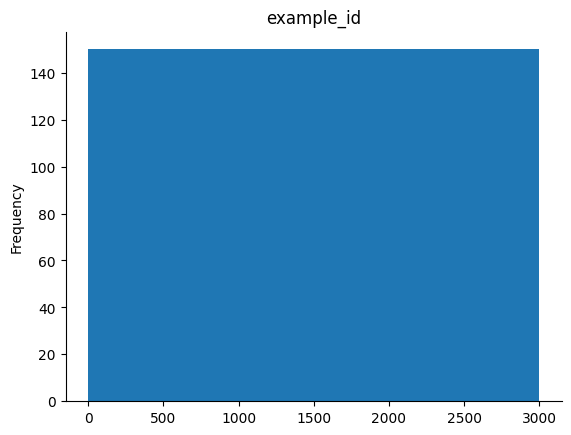

In [160]:
# @title example_id

from matplotlib import pyplot as plt
bakeoff_df['example_id'].plot(kind='hist', bins=20, title='example_id')
plt.gca().spines[['top', 'right',]].set_visible(False)

*To* enter the bakeoff, you simply need to use your original system to:

1. Add a column named 'prediction' to `cs224u-sentiment-test-unlabeled.csv` with your model predictions (which are strings in {`positive`, `negative`, `neutral`}). The existing columns should remain.

2. Save the file as `cs224u-sentiment-bakeoff-entry.csv`. Here is a good snippet of code for writing this file:

In [163]:
bakeoff_df = pd.read_csv(
    os.path.join("data", "sentiment", "cs224u-sentiment-test-unlabeled.csv"))

# Generating predictions using the trained model
# Use the `predict` method of the `BertClassifier` instance:
bakeoff_df['prediction'] = bert_finetune.predict(bakeoff_df['sentence'].tolist())

In particular, you need to be sure that `example_id` is a column rather than an index when read in by Pandas. Here is a quick test:

In [164]:
def test_bakeoff_entry(filename="cs224u-sentiment-bakeoff-entry.csv"):
    gold_df = pd.read_csv(
        os.path.join("data", "sentiment", "cs224u-sentiment-test-unlabeled.csv"))
    entry_df = pd.read_csv(filename)

    # Check that no required columns are missing:
    expected_cols = {'example_id', 'sentence', 'prediction'}
    missing_cols = expected_cols - set(entry_df.columns)
    errcount = 0
    if len(missing_cols) != 0:
        errcount += 1
        print(f"Entry is missing required columns {missing_cols}")
        return

    # Check that the predictions are in our space:
    labels = {'positive', 'negative', 'neutral'}
    predtypes = set(entry_df.prediction.unique())
    unexpected = predtypes - labels
    if len(unexpected) != 0:
        errcount += 1
        print(f"Prediction column has unexpected values: {unexpected}")

    # Check that the dataset hasn't been rearranged:
    for colname in ('example_id', 'sentence'):
        if not entry_df[colname].equals(gold_df[colname]):
            errcount += 1
            print(f"Entry is misaligned with test data on column {colname}")

    # Clean bill of health:
    if errcount == 0:
        print("No errors detected with `test_bakeoff_entry`.")

In [165]:
test_bakeoff_entry("cs224u-sentiment-bakeoff-entry.csv")

Entry is missing required columns {'prediction'}


Submit the following files to Gradescope:

* `hw_sentiment.ipynb` (this notebook)
* `cs224u-sentiment-bakeoff-entry.csv` (bake-off output)

Please make sure you use these filenames. The autograder looks for files with these names.

You are not permitted to do any tuning of your system based on what you see in our bakeoff prediction file – you should not study that file in anyway, beyond perhaps checking that it contains what you expected it to contain. The upload function will do some additional checking to ensure that your file is well-formed.

People who enter will receive the additional homework point, and people whose systems achieve the top score will receive an additional 0.5 points. We will test the top-performing systems ourselves, and only systems for which we can reproduce the reported results will win the extra 0.5 points.

Late entries will be accepted, but they cannot earn the extra 0.5 points.